In [1]:
import dgl
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, gen_q_dict_mis_handcrafted, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_backtest import max_drawdown_series, annualized_sharpe_ratio, annualized_sortino_ratio, \
    annualized_max_drawdown, annualized_calmar_ratio
from utils_distance_correlation import df_distance_correlation

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [3]:
RISK_FREE_RATE = 0.01
QUANTILE = 0.2

## Read in Data

In [4]:
hist_prices_df = pd.read_csv(
    "./data/etf_hist_prices.csv",
    parse_dates=["Date"],
    index_col="Date"
)
hist_prices_df

,AAXJ,ACWX,AGG,AGQ,AGZ,AMLP,ANGL,AOK,AOR,ASHR,...,XLV,XLY,XME,XOP,XRT,YANG,YINN,YYY,ZROZ,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,49.333683,36.135860,85.134140,66.320000,94.718872,40.978897,16.375187,25.891409,30.742685,17.339821,...,47.490868,59.389507,36.674202,231.718124,38.211926,554.267700,509.904602,11.425961,67.096748,170.839996
2014-01-03,49.054714,36.127968,85.166084,67.720001,94.513702,40.909138,16.381254,25.940166,30.774855,17.261005,...,47.602837,59.228798,36.330242,229.611862,38.281853,576.003723,489.126526,11.445757,67.064507,167.039993
2014-01-06,48.725037,36.001640,85.278023,67.720001,94.564980,40.839363,16.344831,25.907660,30.710495,16.831091,...,47.404713,58.862759,36.055103,228.368790,37.914761,604.984924,464.979004,11.455651,67.467438,167.199997
2014-01-07,48.953274,36.151661,85.317963,65.599998,94.624817,40.862602,16.448046,25.988928,30.895542,16.866915,...,47.904350,59.219860,35.788521,230.475067,37.975948,604.984924,465.540649,11.539776,67.805893,172.580002
2014-01-08,48.961727,36.151661,85.062187,63.599998,94.488045,40.560276,16.448046,25.956423,30.815084,16.874083,...,48.326458,59.059155,35.530548,229.439194,37.796768,584.698059,479.579926,11.490292,67.435196,177.960007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,64.510002,45.590000,97.006676,31.469999,105.987823,36.260628,26.683306,33.650570,47.421120,27.450001,...,135.571228,129.036224,50.616562,136.504166,60.185707,12.717697,44.288082,11.930000,89.943977,19.650000
2022-12-27,65.760002,45.880001,96.303658,32.250000,105.661072,36.135956,26.351957,33.501579,47.331474,28.219999,...,135.222580,126.942627,51.025162,137.396866,59.498043,10.931891,50.579399,11.830000,87.411591,19.190001
2022-12-28,64.419998,45.320000,96.135315,30.770000,105.700668,35.598900,26.073992,33.362526,46.913139,27.660000,...,134.345993,125.875885,48.982162,131.296722,58.621021,11.928391,45.552315,11.570000,86.426231,20.100000


In [5]:
assert not hist_prices_df.isnull().any().any(), "DataFrame contains NaN values!"

### S&P500 as Benchmark

In [6]:
gspc = yf.download(
    tickers="^GSPC", 
    start=hist_prices_df.index[0].strftime(format="%Y-%m-%d"), 
    end=hist_prices_df.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
2014-01-08    1837.489990
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2265, dtype: float64

In [17]:
hist_prices_df.index[0].strftime(format="%Y-%m-%d")

'2014-01-02'

In [23]:
START_DATE = hist_prices_df.index[0].strftime(format="%Y-%m-%d")
END_DATE =  hist_prices_df.index[-1].strftime(format="%Y-%m-%d")
print(f"Start date: {START_DATE}\nEnd date: {END_DATE}")
OFFSET = 3 # years

slices = []
for i, year in enumerate(hist_prices_df.index.year.unique()):
    if i < OFFSET:
        pass
    elif i+1 >= len(hist_prices_df.index.year.unique()):
        pass
    else:   
        print(year, year-OFFSET, year+1)


Start date: 2014-01-02
End date: 2022-12-30
2017 2014 2018
2018 2015 2019
2019 2016 2020
2020 2017 2021
2021 2018 2022


In [7]:
TRAIN_START_DATE, TRAIN_END_DATE = "2014-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = hist_prices_df.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = hist_prices_df.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = hist_prices_df.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 414)
Validation shape: (505, 414)
Test shape: (503, 414)


### Build correlation matrix

In [14]:
def build_corr_matrices(df_train_pct):
    df_train_pct = df_train.pct_change()
    df_train_pct = df_train_pct.iloc[1:]
    assert df_train_pct.isnull().any

    # Pearson
    df_corr_pearson = df_train_pct.corr(method='pearson').abs()
    print(f"Median Correlation Value: {df_corr_pearson.quantile(0.5).mean():.4f}")  

    # Handcrafted correlation matrix
    df_corr_daily = df_train_pct.corr(method='pearson').abs()
    # Weekly returns
    df_train_weekly = df_train.groupby(pd.Grouper(freq='W')).mean()
    df_train_weekly_pct = df_train_weekly.pct_change()
    df_corr_weekly = df_train_weekly_pct.corr(method='pearson').abs()
    # Monthly returns
    df_train_monthly = df_train.groupby(pd.Grouper(freq='M')).mean()
    df_train_monthly_pct = df_train_monthly.pct_change()
    df_corr_monthly = df_train_monthly_pct.corr(method='pearson').abs()
    # Drawdowns
    df_train_mdd = max_drawdown_series(df_train_pct)
    df_corr_mdd = df_train_mdd.corr(method='pearson').abs()
    # Final correlation matrix
    df_corr_handcrafted = (df_corr_daily + df_corr_weekly + df_corr_monthly + df_corr_mdd) / 4
    print(f"Median Correlation Value: {df_corr_handcrafted.quantile(0.5).mean():.4f}")

    # Quantile Correlation
    df_train_q = pd.DataFrame(
        data=np.where(df_train_pct <= df_train_pct.quantile(QUANTILE), 1, 0),
        index=df_train_pct.index,
        columns=df_train_pct.columns
    )
    df_corr_quantile = df_train_q.corr(method='pearson').abs()
    print(f"Median Correlation Value: {df_corr_quantile.quantile(0.5).mean():.4f}")

    return df_corr_pearson, df_corr_handcrafted, df_corr_quantile


In [13]:
df_corr_pearson, df_corr_handcrafted, df_corr_quantile = build_corr_matrices()
STOCK_NAMES = df_corr_pearson.columns.values

## Build Graph

In [14]:
THRESHOLD = 0.5
THRESHOLD_Q = 0.3

# pearson correlation graph
print("Building 'Pearson Correlation' graph...")
nx_graph_pearson = build_nx_graph(
    df_corr=df_corr_pearson,
    threshold=THRESHOLD
)
assert (df_corr_pearson.where(df_corr_pearson >= THRESHOLD).count().sum() - len(df_corr_pearson)) / 2 == len(nx_graph_pearson.edges)

# # distance correlation graph
# print("Building 'Distance Correlation' graph...")
# nx_graph_dcor = build_nx_graph(
#     df_corr=df_corr_dcor,
#     threshold=THRESHOLD
# )
# assert (df_corr_dcor.where(df_corr_dcor >= THRESHOLD).count().sum() - len(df_corr_dcor)) / 2 == len(nx_graph_dcor.edges)

# handcrafted correlation graph
print("Building 'Handcrafted Correlation' graph...")
nx_graph_handcrafted = build_nx_graph(
    df_corr=df_corr_handcrafted,
    threshold=THRESHOLD
)
assert (df_corr_handcrafted.where(df_corr_handcrafted >= THRESHOLD).count().sum() - len(df_corr_handcrafted)) / 2 == len(nx_graph_handcrafted.edges)

# quantile correlation graph
print("Building 'Quantile Correlation' graph...")
nx_graph_quantile = build_nx_graph(
    df_corr=df_corr_quantile,
    threshold=THRESHOLD_Q
)
assert (df_corr_quantile.where(df_corr_quantile >= THRESHOLD_Q).count().sum() - len(df_corr_quantile)) / 2 == len(nx_graph_quantile.edges)

Building 'Pearson Correlation' graph...
Building 'Handcrafted Correlation' graph...
Building 'Quantile Correlation' graph...


In [15]:
print(f"#Edges Pearson Correlation Graph: {len(nx_graph_pearson.edges)}")
# print(f"#Edges Distnace Correlation Graph: {len(nx_graph_dcor.edges)}")
print(f"#Edges Handcrafted Correlation Graph: {len(nx_graph_handcrafted.edges)}")
print(f"#Edges Quantile Correlation Graph: {len(nx_graph_quantile.edges)}")


#Edges Pearson Correlation Graph: 39978
#Edges Handcrafted Correlation Graph: 37272
#Edges Quantile Correlation Graph: 34560


### Plot degree distribution

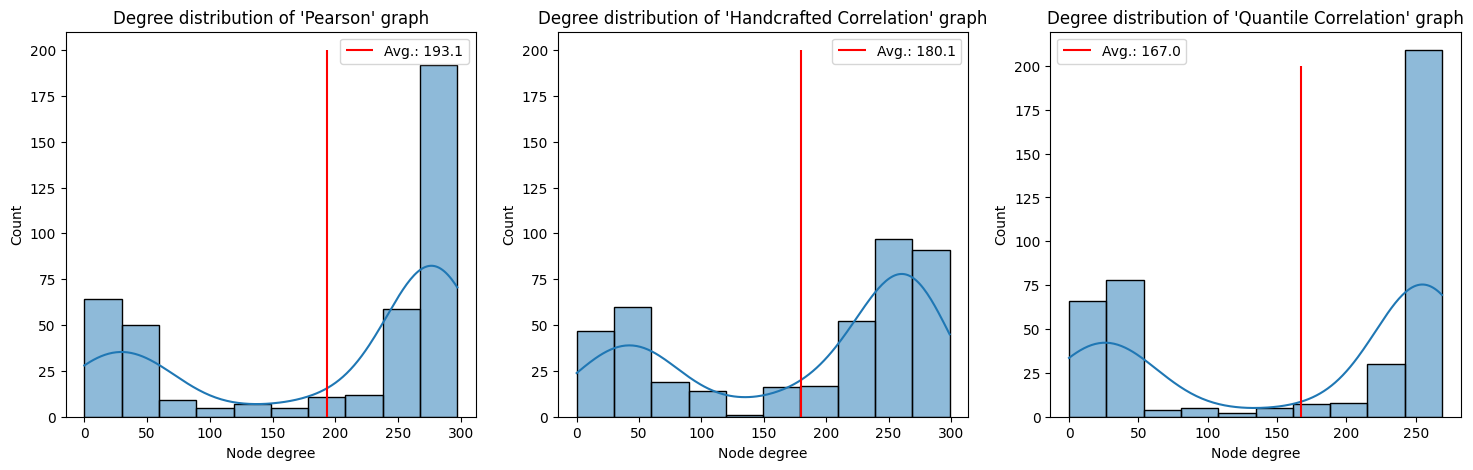

In [16]:
def plot_degree_distr(graph:nx.Graph, ax:plt.Axes, title:str) -> None:
    """ Plots the degree distribution of a graph."""
    degrees = [degree for (_, degree) in graph.degree()]
    avg_degree = sum(degrees) / len(degrees)

    sns.histplot(degrees, kde=True, ax=ax)
    ax.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
    ax.set_title(title)
    ax.set_xlabel("Node degree")
    ax.legend()
    # plt.show()

_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Pearson correlation graph
plot_degree_distr(
    graph=nx_graph_pearson, 
    ax=ax0, 
    title="Degree distribution of 'Pearson' graph")

# # Distance correlation graph
# plot_degree_distr(
#     graph=nx_graph_dcor, 
#     ax=ax1, 
#     title="Degree distribution of 'Distance Correlation' graph")

# Distance correlation graph
plot_degree_distr(
    graph=nx_graph_handcrafted, 
    ax=ax1, 
    title="Degree distribution of 'Handcrafted Correlation' graph")


# Distance correlation graph
plot_degree_distr(
    graph=nx_graph_quantile, 
    ax=ax2, 
    title="Degree distribution of 'Quantile Correlation' graph")

plt.show()



### Build Q matrix

In [17]:
rewards = annualized_sortino_ratio(df_returns=df_train_pct, risk_free_rate=RISK_FREE_RATE, name='Sortino').mean().sort_values(ascending=False)[:20]
rewards

GSY     3.444917
MINT    2.450226
MLN     1.825330
IHI     1.821341
USMV    1.801503
PGF     1.799429
FPE     1.756357
PZA     1.686328
PSK     1.679959
ITM     1.636067
DIA     1.604061
SPLV    1.601124
HYMB    1.594138
DDM     1.587606
SPGP    1.583764
TFI     1.582932
FTCS    1.576415
SPHD    1.556252
UDOW    1.552350
MUB     1.535918
dtype: float64

In [18]:
# Pearson graph
graph_dgl_pearson = dgl.from_networkx(nx_graph=nx_graph_pearson)
graph_dgl_pearson = graph_dgl_pearson.to(TORCH_DEVICE)

q_torch_pearson = qubo_dict_to_torch(
    nx_G=nx_graph_pearson, 
    Q=gen_q_dict_mis(nx_G=nx_graph_pearson, penalty=2), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# # Distance correlation graph
# graph_dgl_dcor = dgl.from_networkx(nx_graph=nx_graph_dcor)
# graph_dgl_dcor = graph_dgl_dcor.to(TORCH_DEVICE)

# q_torch_dcor = qubo_dict_to_torch(
#     nx_G=nx_graph_dcor, 
#     Q=gen_q_dict_mis(nx_G=nx_graph_dcor, penalty=3), 
#     torch_dtype=TORCH_DTYPE, 
#     torch_device=TORCH_DEVICE)

# Handcrafted correlation graph
graph_dgl_handcrafted = dgl.from_networkx(nx_graph=nx_graph_handcrafted)
graph_dgl_handcrafted = graph_dgl_handcrafted.to(TORCH_DEVICE)

rewards = annualized_sortino_ratio(
    df_returns=df_train_pct,
    risk_free_rate=RISK_FREE_RATE, 
    name='Sortino'
    ).mean() * -1

q_torch_handcrafted = qubo_dict_to_torch(
    nx_G=nx_graph_handcrafted, 
    Q=gen_q_dict_mis_handcrafted(nx_G=nx_graph_handcrafted, rewards=rewards, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Quantile graph
graph_dgl_quantile = dgl.from_networkx(nx_graph=nx_graph_quantile)
graph_dgl_quantile = graph_dgl_quantile.to(TORCH_DEVICE)

q_torch_quantile = qubo_dict_to_torch(
    nx_G=nx_graph_quantile, 
    # Q=gen_q_dict_mis(nx_G=nx_graph_quantile, penalty=2), 
    Q=gen_q_dict_mis_handcrafted(nx_G=nx_graph_quantile, rewards=rewards, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

In [19]:
q_torch_pearson

tensor([[-1.,  2.,  0.,  ...,  2.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  2.,  0.,  0.],
        [ 0.,  0., -1.,  ...,  0.,  2.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., -1.]])

In [20]:
q_torch_handcrafted

tensor([[-0.7589,  3.0000,  0.0000,  ...,  3.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5977,  0.0000,  ...,  3.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.9177,  ...,  0.0000,  3.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2787,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.9540,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1586]])

### Visualize graph

Plotting pearson graph...
Plotting handcrafted correlation graph...
Plotting quantile graph...


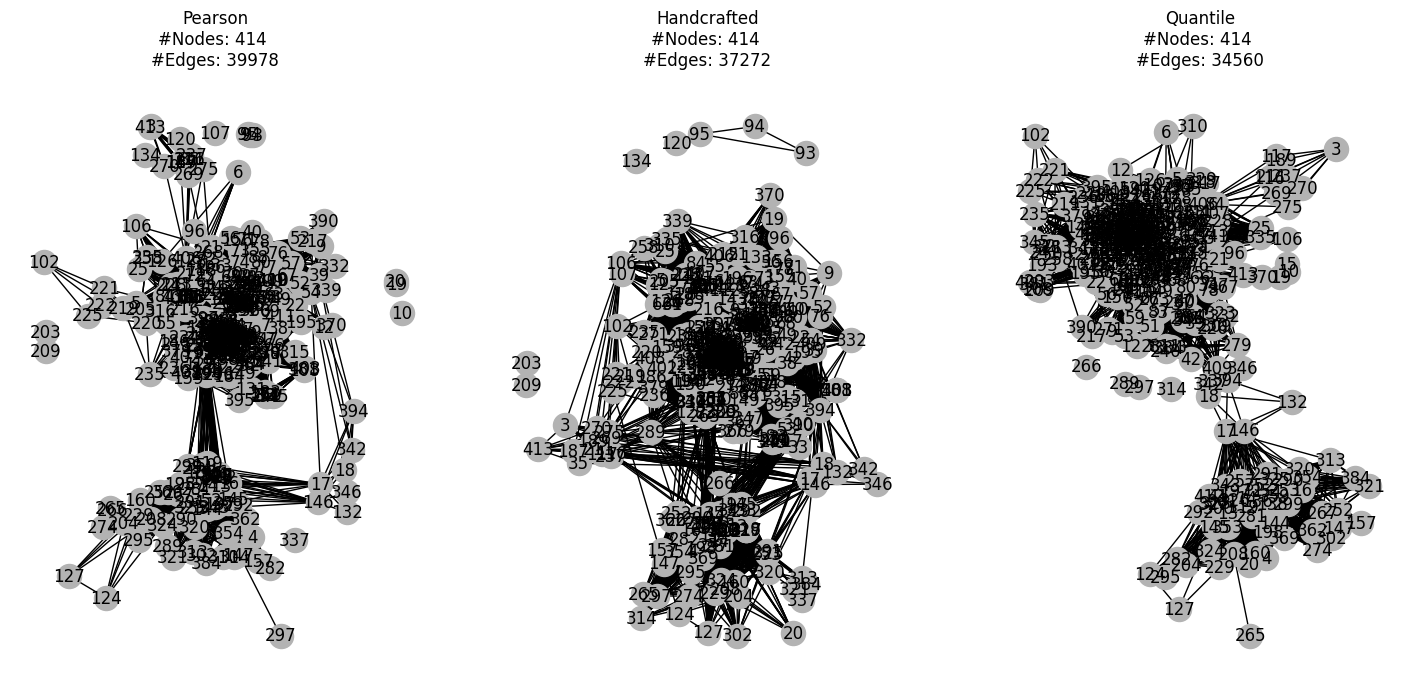

In [21]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

print("Plotting pearson graph...")
pos_pearson = nx.kamada_kawai_layout(nx_graph_pearson)
ax0.set_title(f"Pearson\n#Nodes: {nx_graph_pearson.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_pearson.number_of_edges()}")
nx.draw(nx_graph_pearson, pos_pearson, with_labels=True, node_color=[[.7, .7, .7]], ax=ax0)

# print("Plotting distance correlation graph...")
# pos_dcor = nx.kamada_kawai_layout(nx_graph_dcor)
# ax1.set_title(f"Distance Correlation\n#Nodes: {nx_graph_dcor.number_of_nodes()} \n" \
#               f"#Edges: {nx_graph_dcor.number_of_edges()}")
# nx.draw(nx_graph_dcor, pos_dcor, with_labels=True, node_color=[[.7, .7, .7]], ax=ax1)

print("Plotting handcrafted correlation graph...")
pos_handrafted = nx.kamada_kawai_layout(nx_graph_handcrafted)
ax1.set_title(f"Handcrafted\n#Nodes: {nx_graph_handcrafted.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_handcrafted.number_of_edges()}")
nx.draw(nx_graph_handcrafted, pos_handrafted, with_labels=True, node_color=[[.7, .7, .7]], ax=ax1)

print("Plotting quantile graph...")
pos_quantile = nx.kamada_kawai_layout(nx_graph_quantile)
ax2.set_title(f"Quantile\n#Nodes: {nx_graph_quantile.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_quantile.number_of_edges()}")
nx.draw(nx_graph_quantile, pos_quantile, with_labels=True, node_color=[[.7, .7, .7]], ax=ax2)

## Set up GNN

In [22]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 25_000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [23]:
assert nx_graph_pearson.number_of_nodes() == nx_graph_quantile.number_of_nodes()
assert nx_graph_quantile.number_of_nodes() == nx_graph_handcrafted.number_of_nodes()
assert nx_graph_pearson.number_of_nodes() == nx_graph_handcrafted.number_of_nodes()

n = nx_graph_pearson.number_of_nodes()

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [24]:
training_inputs = [
    ('pearson', graph_dgl_pearson, q_torch_pearson, nx_graph_pearson),
    # ('dcor', graph_dgl_dcor, q_torch_dcor, nx_graph_dcor),
    ('handcrafted', graph_dgl_handcrafted, q_torch_handcrafted, nx_graph_handcrafted),
    ('quantile', graph_dgl_quantile, q_torch_quantile, nx_graph_quantile)
    ]
training_results = {}

for (name, dgl_graph, q_torch, nx_graph) in training_inputs:
    print(f"\nRunning GNN training for {name} graph...")

    gnn_start = time()
    
    net, embed, optimizer = get_gnn(
        n_nodes=n,
        params=params, 
        model_type='SAGE_2L_Model', 
        torch_device=TORCH_DEVICE, 
        torch_dtype=TORCH_DTYPE
    )
    
    net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
        q_torch=q_torch, 
        dgl_graph=dgl_graph, 
        net=net, 
        embed=embed, 
        optimizer=optimizer, 
        number_epochs=params['number_epochs']+1,
        tol=params['tolerance'], 
        patience=params['patience'], 
        prob_threshold=params['prob_threshold']
    )
    
    gnn_runtime = time() - gnn_start
    
    training_results[name] = {}
    training_results[name]['net'] = net
    training_results[name]['epoch'] = epoch
    training_results[name]['final_bitstring'] = final_bitstring
    training_results[name]['best_bitstring'] = best_bitstring
    training_results[name]['best_loss'] = best_loss.item()
    training_results[name]['loss_hist'] = loss_hist
    training_results[name]['epoch_hist'] = epoch_hist
    training_results[name]['gnn_runtime'] = gnn_runtime

    print(f"Graph post-processing...")
    final_loss = loss_func(final_bitstring.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in final_bitstring])

    # Process bitstring reported by GNN
    size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)

    training_results[name]['final_loss'] = final_loss.item()
    training_results[name]['size_mis_gnn'] = size_mis_gnn.item()
    training_results[name]['ind_set_gnn'] = ind_set_gnn
    training_results[name]['number_violations_gnn'] = number_violations_gnn




Running GNN training for pearson graph...
Epoch: 0, Loss: 76616.40625
Epoch: 1000, Loss: 33.6641960144043
Epoch: 2000, Loss: -16.29952049255371
Epoch: 3000, Loss: -13.61572265625
Epoch: 4000, Loss: 145.0187530517578
Epoch: 5000, Loss: -19.059814453125
Epoch: 6000, Loss: -20.2014102935791
Epoch: 7000, Loss: -20.783523559570312
Epoch: 8000, Loss: -20.42285919189453
Epoch: 9000, Loss: -19.947568893432617
Epoch: 10000, Loss: -20.483346939086914
Epoch: 11000, Loss: -20.962398529052734
Epoch: 12000, Loss: -19.08821678161621
Epoch: 13000, Loss: -20.95767593383789
Epoch: 14000, Loss: -21.596609115600586
Epoch: 15000, Loss: -21.91520881652832
Epoch: 16000, Loss: -21.174299240112305
Epoch: 17000, Loss: -23.329620361328125
Epoch: 18000, Loss: -23.912235260009766
Epoch: 19000, Loss: -24.525554656982422
Epoch: 20000, Loss: -24.718740463256836
Epoch: 21000, Loss: -27.94314956665039
Epoch: 22000, Loss: -35.04856491088867
Epoch: 23000, Loss: -35.760719299316406
Epoch: 24000, Loss: -36.97085952758789


## Post-process GNN Results

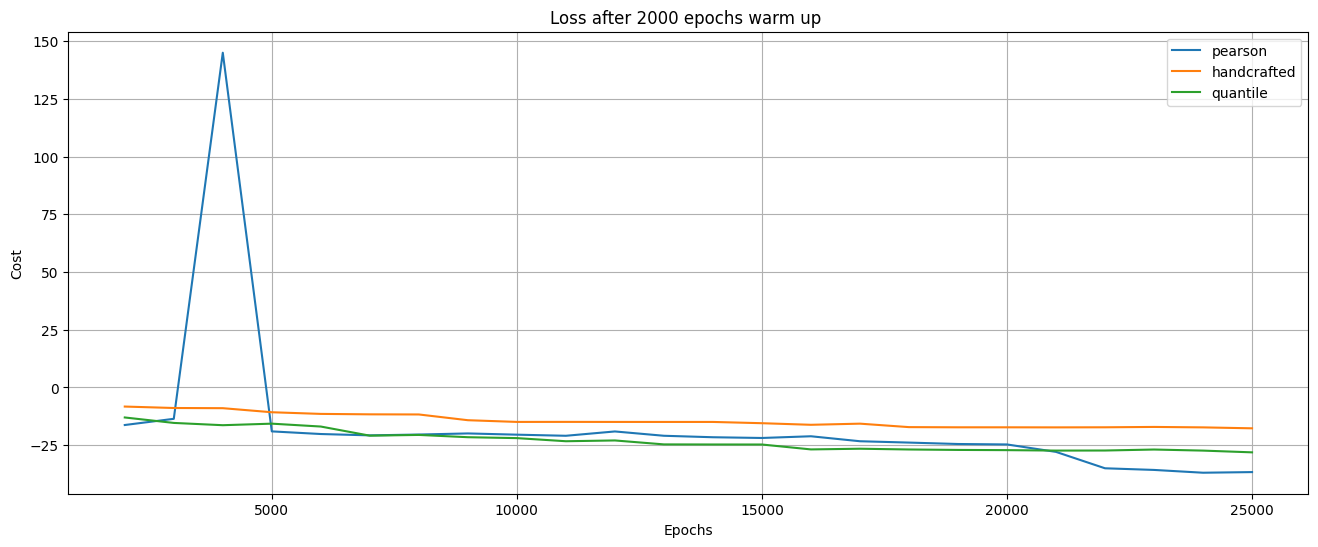

In [25]:
_, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

name = 'pearson'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

# name = 'dcor'
# tr_res_dict = training_results[name]
# ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'handcrafted'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'quantile'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

ax0.set_title("Loss after 2000 epochs warm up ")
ax0.set_ylabel("Cost")
ax0.set_xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

In [26]:
# Distance Correlation:
# --------
#     MIS size:       {training_results['dcor']['size_mis_gnn']}
#     Violations:     {training_results['dcor']['number_violations_gnn']}
#     Runtime (s):    {training_results['dcor']['gnn_runtime']:.1f}

In [27]:
s = f"""
Pearson:
--------
    MIS size:       {training_results['pearson']['size_mis_gnn']}
    Violations:     {training_results['pearson']['number_violations_gnn']}
    Runtime (s):    {training_results['pearson']['gnn_runtime']:.1f}

Handcrafted:
--------
    MIS size:       {training_results['handcrafted']['size_mis_gnn']}
    Violations:     {training_results['handcrafted']['number_violations_gnn']}
    Runtime (s):    {training_results['handcrafted']['gnn_runtime']:.1f}

Quantile Correlation:
--------
    MIS size:       {training_results['quantile']['size_mis_gnn']}
    Violations:     {training_results['quantile']['number_violations_gnn']}
    Runtime (s):    {training_results['quantile']['gnn_runtime']:.1f}
"""

print(s)


Pearson:
--------
    MIS size:       38
    Violations:     0
    Runtime (s):    255.6

Handcrafted:
--------
    MIS size:       20
    Violations:     0
    Runtime (s):    259.0

Quantile Correlation:
--------
    MIS size:       37
    Violations:     0
    Runtime (s):    258.0



Plotting pearson graph...
Plotting handcrafted graph...
Plotting quantile graph...


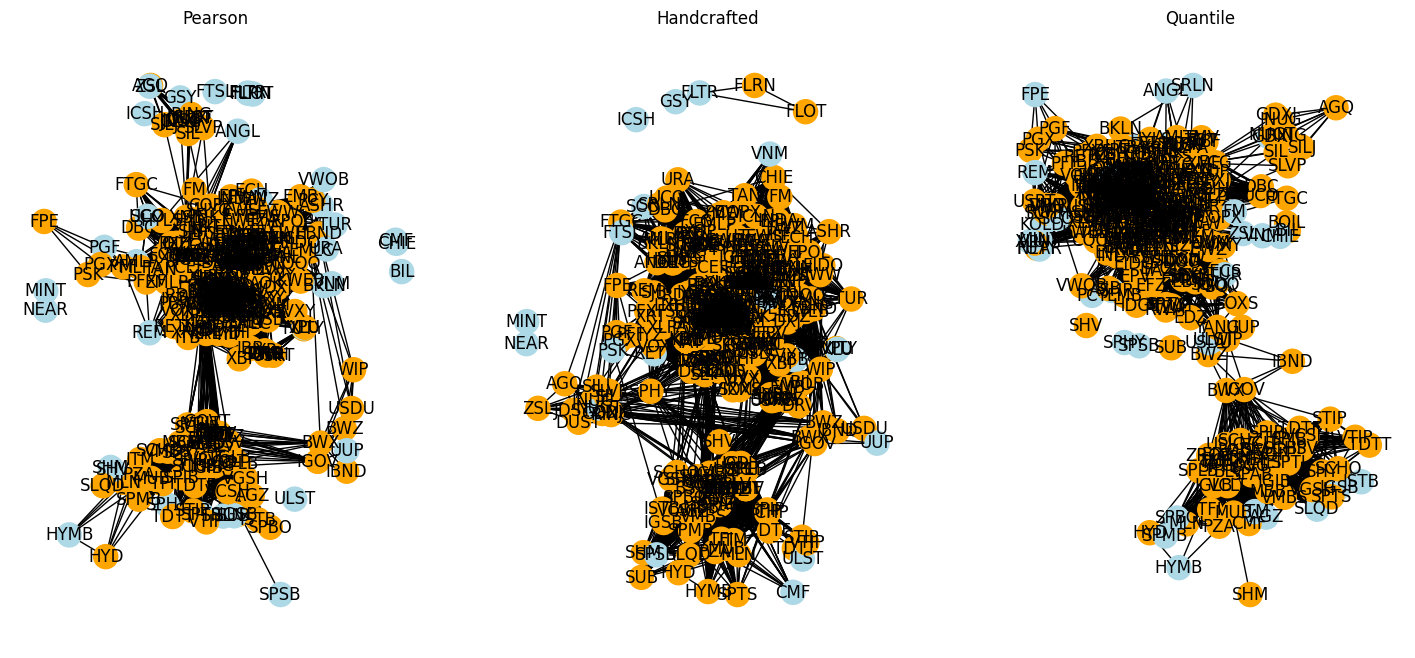

In [28]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_pearson = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# # Distance Correlation
# name = 'dcor'
# ax = ax1
# print(f"Plotting {name} graph...")
# best_bitstring = training_results[name]['best_bitstring']
# gnn_mis_set_dcor = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

# color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_dcor.nodes]
# nx_graph_labelled = nx.relabel_nodes(nx_graph_dcor, lambda x: STOCK_NAMES[x])
# pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

# ax.set_title(f"{name.capitalize()}")
# nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Handcrafted
name = 'handcrafted'
ax = ax1
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_handcrafted = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_handcrafted.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_handcrafted, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Quantile
name = 'quantile'
ax = ax2
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_quantile = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_quantile.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_quantile, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

plt.show()

In [29]:
n_intersec = len(set(gnn_mis_set_pearson) & set(gnn_mis_set_quantile) & set(gnn_mis_set_handcrafted))
s = f"""
Size of Intersection:               {n_intersec}

Size Independent Set    | % of Intersction
------------------------------------------
Pearson:        {len(gnn_mis_set_pearson)}     |  {(n_intersec / len(gnn_mis_set_pearson) * 100):.1f} %
Handcrafted:    {len(gnn_mis_set_handcrafted)}     |  {(n_intersec / len(gnn_mis_set_handcrafted) * 100):.1f} %
Quantile:       {len(gnn_mis_set_quantile)}     |  {(n_intersec / len(gnn_mis_set_quantile) * 100):.1f} %
"""
print(s)


Size of Intersection:               10

Size Independent Set    | % of Intersction
------------------------------------------
Pearson:        38     |  26.3 %
Handcrafted:    20     |  50.0 %
Quantile:       37     |  27.0 %



## Compare against traditional solver

In [30]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_pearson)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=414).
Calculating violations...
Independence number found by nx solver is 46 with 0 violations.
MIS solver took 4.544s


In [31]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

Plotting pearson graph...


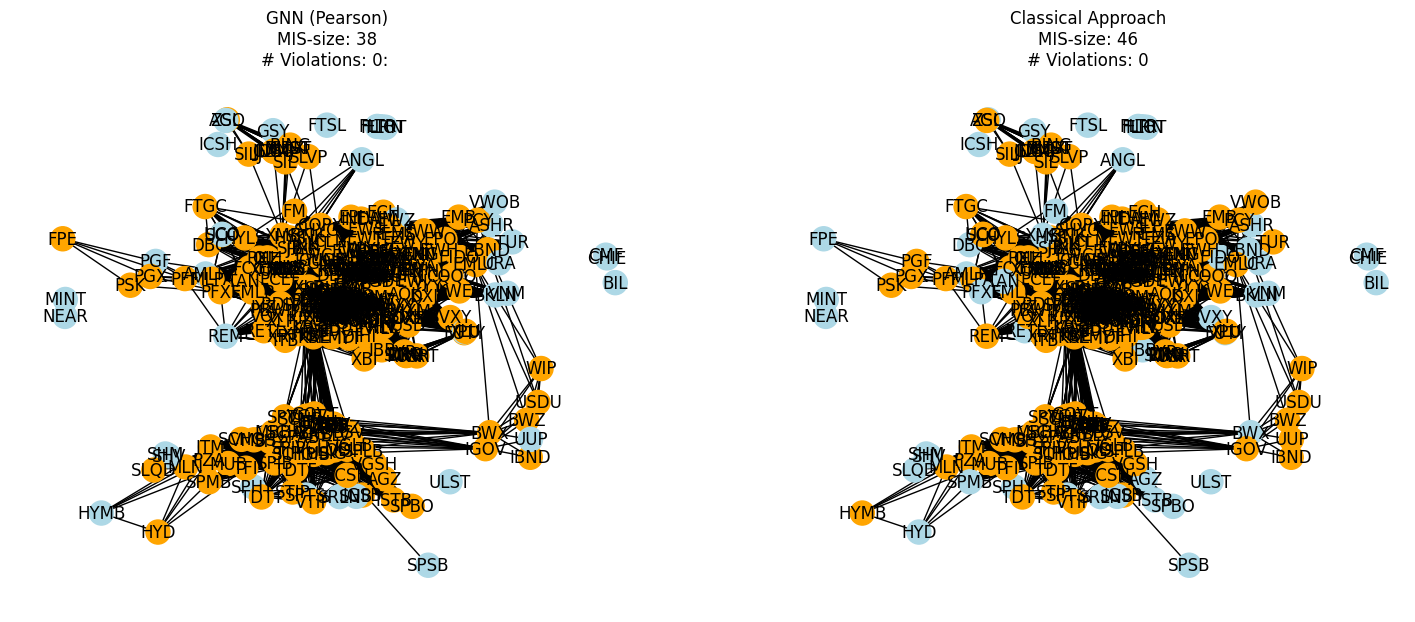

In [32]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (Pearson)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

## Backtest

In [33]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

## Portfolios

In [34]:
etf_metadata = pd.read_csv(
    "./etf_tickers_metadata.csv",
    usecols=['ticker', 'category'])
etf_metadata

,ticker,category
0,AAA,Ultrashort Bond
1,AADR,Foreign Large Growth
2,AAPB,Trading--Leveraged Equity
3,AAPD,Trading--Inverse Equity
4,AAPU,Trading--Leveraged Equity
...,...,...
2595,ZIVB,Trading--Inverse Equity
2596,ZROZ,Long Government
2597,ZSL,Trading--Inverse Commodities
2598,ZSPY,Long-Short Equity


In [35]:
person_portfolio = etf_metadata[etf_metadata['ticker'].isin(gnn_mis_set_pearson)]
person_portfolio_by_cat = person_portfolio.loc[:, 'category'].value_counts()
person_portfolio_by_cat = person_portfolio_by_cat.to_frame()
person_portfolio_by_cat['category'] = person_portfolio_by_cat.index
person_portfolio_by_cat['portfolio'] = "Pearson"

handcrafted_portfolio = etf_metadata[etf_metadata['ticker'].isin(gnn_mis_set_handcrafted)]
handcrafted_portfolio_by_cat = handcrafted_portfolio.loc[:, 'category'].value_counts()
handcrafted_portfolio_by_cat = handcrafted_portfolio_by_cat.to_frame()
handcrafted_portfolio_by_cat['category'] = handcrafted_portfolio_by_cat.index
handcrafted_portfolio_by_cat['portfolio'] = "Handcrafted"

quantile_portfolio = etf_metadata[etf_metadata['ticker'].isin(gnn_mis_set_quantile)]
quantile_portfolio_by_cat = quantile_portfolio.loc[:, 'category'].value_counts()
quantile_portfolio_by_cat = quantile_portfolio_by_cat.to_frame()
quantile_portfolio_by_cat['category'] = quantile_portfolio_by_cat.index
quantile_portfolio_by_cat['portfolio'] = "Quantile"

portfolios_by_cat = pd.concat([person_portfolio_by_cat, handcrafted_portfolio_by_cat, quantile_portfolio_by_cat], axis=0)
portfolios_by_cat.fillna(0.0, inplace=True)

# person_portfolio_by_cat = person_portfolio_by_cat.to_frame()
# person_portfolio_by_cat['portfolio'] = "Pearson"
# person_portfolio_by_cat['category'] = person_portfolio_by_cat.index

# portfolios_by_cat

# plt.barh(person_portfolio_by_cat.index, person_portfolio_by_cat.values, label="Pearson")
# plt.barh(handcrafted_portfolio_by_cat.index, handcrafted_portfolio_by_cat.values, label="Handcrafted")

# plt.legend()
# # plt.grid()
# plt.show()



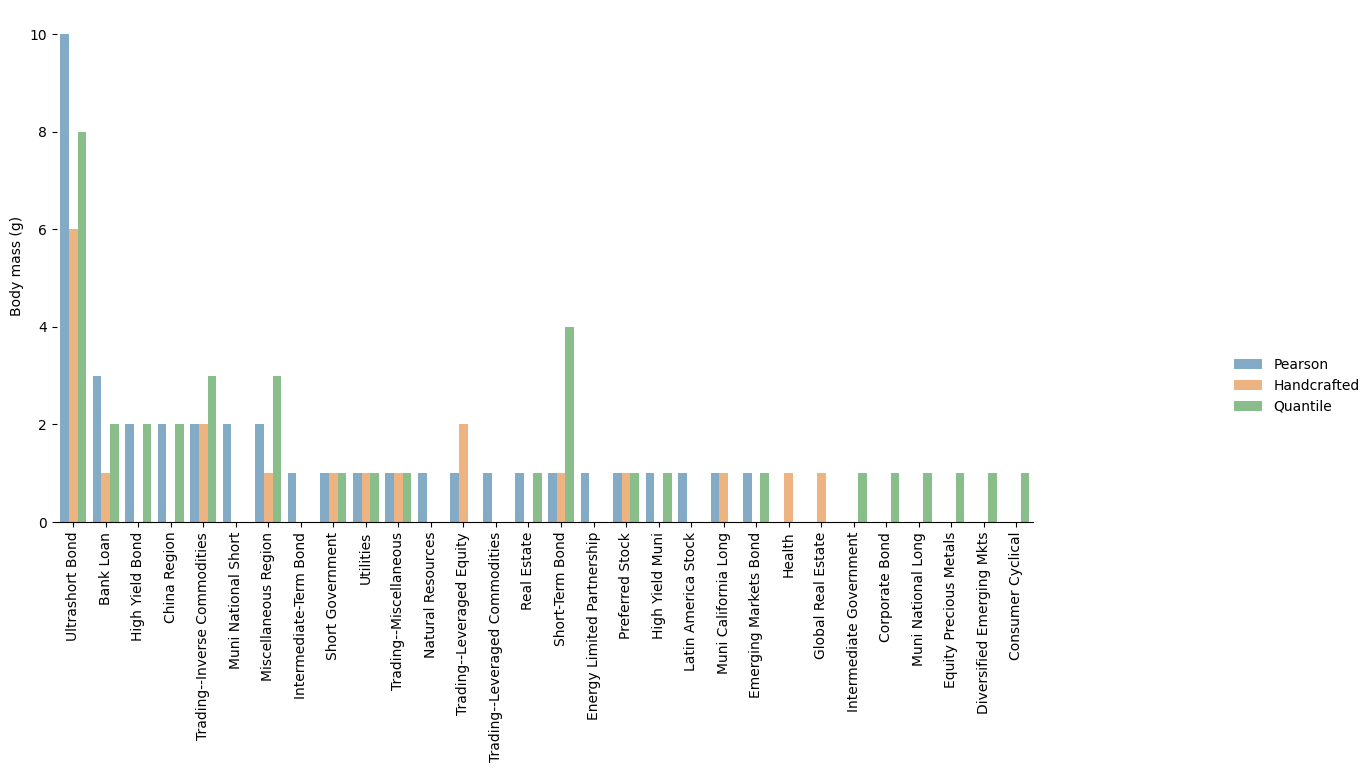

In [36]:
g = sns.catplot(
    data=portfolios_by_cat,
    kind='bar',
    x='category',
    y='count',
    hue='portfolio',
    alpha=.6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
g.fig.set_figheight(6)
g.fig.set_figwidth(15)
g.set_xticklabels(rotation=90)
plt.show()

### Training

In [37]:
ALPHA_VAL_LOW = 0.2
ALPHA_VAL_HIGH = 1.0

# stocks in pearson portfolio: 38
# stocks in handcrafted portfolio: 20
# stocks in quantile portfolio: 37
# stocks in solver portfolio: 46


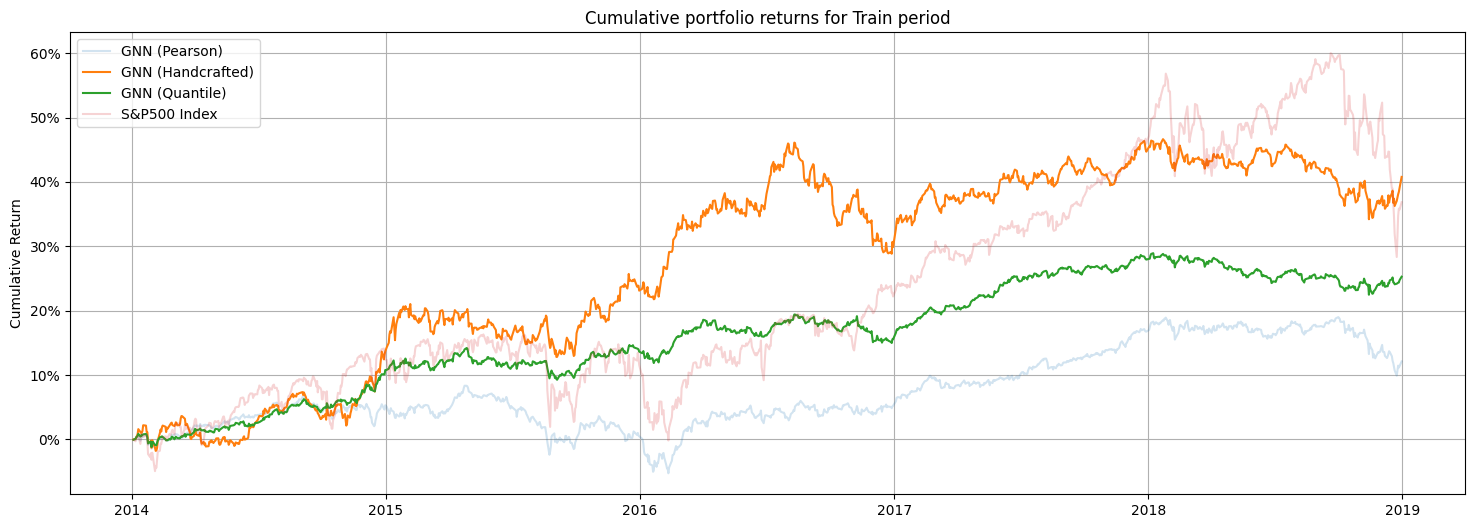

In [38]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_train, gnn_mis_pearson_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_pearson
)

# # GNN DCOR Portfolio
# print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
# gnn_mis_dcor_returns_train, gnn_mis_dcor_returns_cum_train = portfolio_return(
#     df=df_train,
#     assets=gnn_mis_set_dcor
# )

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_train, gnn_mis_handcrafted_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_handcrafted
)

# GNN Quantile Portfolio
print(f"# stocks in quantile portfolio: {len(gnn_mis_set_quantile)}")
gnn_mis_quantile_returns_train, gnn_mis_quantile_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_quantile
)


# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_train, solver_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_train = gspc_train.pct_change()
gspc_returns_cum_train = (gspc_returns_train + 1).cumprod() -1
# gspc_returns_cumsum_train = gspc_returns_train.cumsum()

# Benchmark all assets equally
gspc_equal_returns_train, gspc_equal_returns_cum_train = portfolio_return(
    df=df_train,
    assets=df_train.columns.to_list()
)

# Test
# print(f"# stocks in pearson portfolio: 1")
# gnn_mis_t_returns_train, gnn_mis_t_returns_cum_train = portfolio_return(
#     df=df_train,
#     assets=['ADBE']
# )

# # Not in GNN MIS Portfolio
# ni_gnn_mis_set = list(set(df_train.columns.to_list()) - set(gnn_mis_set))
# not_gnn_mis_returns_train, not_gnn_mis_returns_cum_train = portfolio_return(
#     df=df_train,
#     assets=ni_gnn_mis_set
# )

# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_train, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_returns_cum_train, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_returns_cum_train, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_returns_cum_train, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)
# ax.plot(gnn_mis_t_returns_cum_train, label="Test", alpha=ALPHA_VAL_LOW)


# ax.plot(solver_mis_returns_cum_train, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_returns_cum_train, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_returns_cum_train, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Cumulative portfolio returns for Train period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

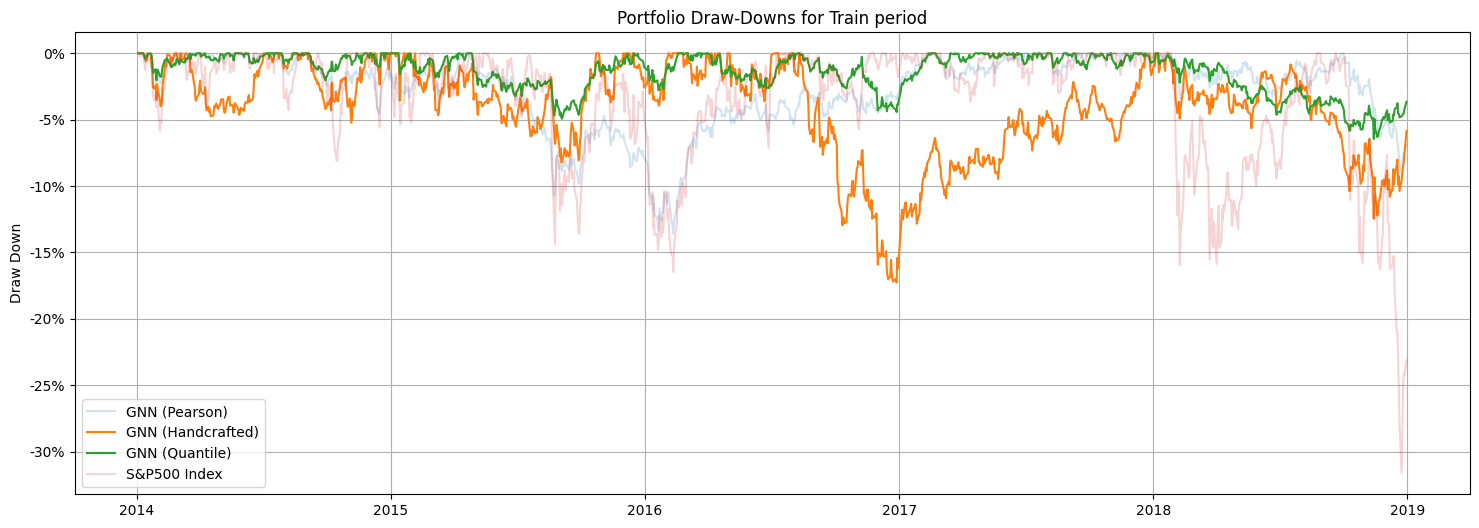

In [39]:
gnn_mis_pearson_mdd_train = drawdown_pct(gnn_mis_pearson_returns_cum_train)
# gnn_mis_dcor_mdd_train = drawdown_pct(gnn_mis_dcor_returns_cum_train)
gnn_mis_handcrafted_mdd_train = drawdown_pct(gnn_mis_handcrafted_returns_cum_train)
gnn_mis_quantile_mdd_train = drawdown_pct(gnn_mis_quantile_returns_cum_train)

solver_mis_mdd_train = drawdown_pct(solver_mis_returns_cum_train)

gspc_mdd_train = drawdown_pct(gspc_returns_cum_train)
gspc_equal_mdd_train = drawdown_pct(gspc_equal_returns_cum_train)


# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_train, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_mdd_train, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_mdd_train, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_mdd_train, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)

# ax.plot(solver_mis_mdd_train, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_mdd_train, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_mdd_train, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Portfolio Draw-Downs for Train period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [40]:
# Sharpe Ratios
df_sharpe_train = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sharpe_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    # annualized_sharpe_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_train['Avg'] = df_sharpe_train.mean(axis=1)
df_sharpe_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_train.index), df_sharpe_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_train.index = multi_idx
df_sharpe_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
Sharpe GNN (Pearson)      0.91 -0.84  0.56  2.60 -0.82  0.48
       GNN (Handcrafted)  1.46  0.76  0.50  1.60 -0.44  0.78
       GNN (Quantile)     2.36  0.36  0.18  3.13 -0.73  1.06
       S&P500 Index       1.00 -0.03  0.68  2.54 -0.35  0.77

In [41]:
# Sortino Ratios
df_sortino_train = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sortino_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    # annualized_sortino_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_sortino_train['Avg'] = df_sortino_train.mean(axis=1)
df_sortino_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_train.index), df_sortino_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_train.index = multi_idx
df_sortino_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric  Portfolio                                            
Sortino GNN (Pearson)      1.20 -1.27  0.83  3.94 -1.20  0.70
        GNN (Handcrafted)  2.36  1.15  0.80  3.12 -0.61  1.37
        GNN (Quantile)     3.55  0.52  0.28  5.82 -1.00  1.83
        S&P500 Index       1.30 -0.05  0.89  3.41 -0.43  1.03

In [42]:
# Maximal Draw Down
df_mdd_train = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_train, name='GNN (Pearson)'),
    # annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_train, name='GNN (Dist. Corr.)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_train, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_returns_train, name='GNN (Quantile)'),
    # annualized_max_drawdown(df_returns=solver_mis_returns_train, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_train, name='S&P500 Index'),
    # annualized_max_drawdown(df_returns=gspc_equal_returns_train, name='S&P500 Equal')

], axis=1).T

df_mdd_train['Avg'] = df_mdd_train.mean(axis=1)
df_mdd_train.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_train.index), df_mdd_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_train.index = multi_idx
df_mdd_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
MDD    GNN (Pearson)     -0.05 -0.11 -0.14 -0.02 -0.09 -0.08
       GNN (Handcrafted) -0.05 -0.08 -0.17 -0.13 -0.12 -0.11
       GNN (Quantile)    -0.02 -0.05 -0.04 -0.03 -0.06 -0.04
       S&P500 Index      -0.08 -0.14 -0.16 -0.04 -0.32 -0.15

In [43]:
# Calmar Ratios
df_calmar_train = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile))'),
    # annualized_calmar_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    # annualized_calmar_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_calmar_train['Avg'] = df_calmar_train.mean(axis=1)
df_calmar_train.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_train.index), df_calmar_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_train.index = multi_idx
df_calmar_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                            
Calmar GNN (Pearson)      0.94 -0.51  0.28  3.90 -0.54  0.81
       GNN (Handcrafted)  2.33  0.91  0.28  0.74 -0.28  0.80
       GNN (Quantile))    4.58  0.34  0.17  3.24 -0.47  1.57
       S&P500             1.39 -0.04  0.54  4.64 -0.19  1.27

### Validation

# stocks in pearson portfolio: 38
# stocks in handcrafted portfolio: 20
# stocks in dist. corr. portfolio: 37
# stocks in solver portfolio: 46


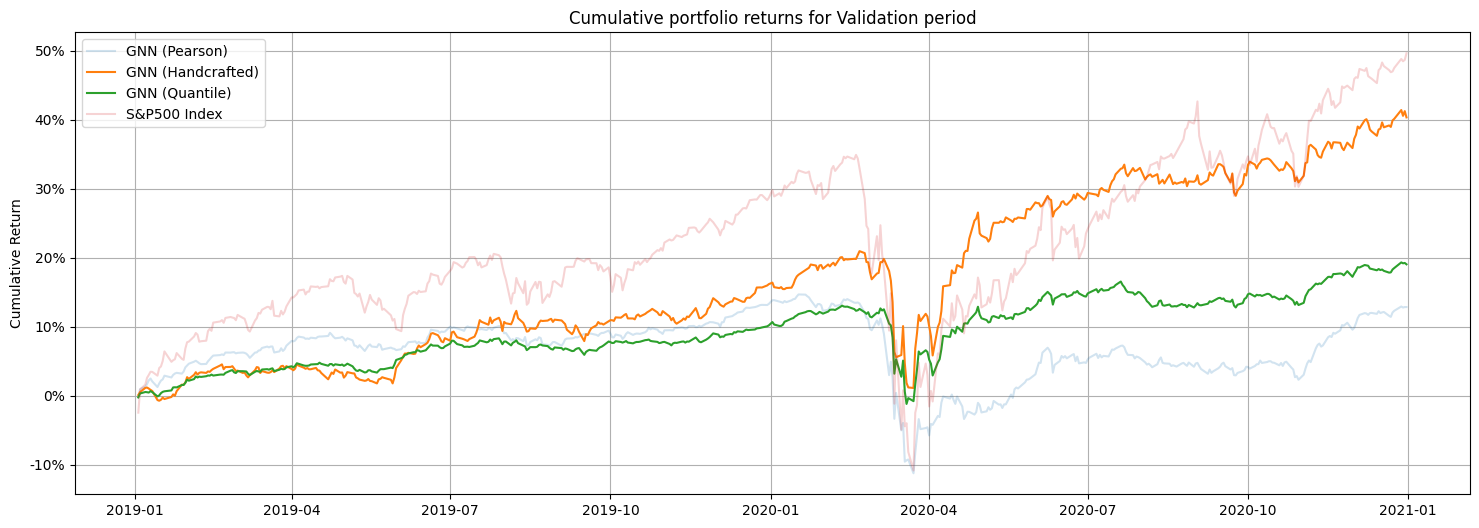

In [44]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_val, gnn_mis_pearson_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_pearson
)

# # GNN DCOR Portfolio
# print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
# gnn_mis_dcor_returns_val, gnn_mis_dcor_returns_cum_val = portfolio_return(
#     df=df_val,
#     assets=gnn_mis_set_dcor
# )

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_val, gnn_mis_handcrafted_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_handcrafted
)

# GNN Quantile Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile)}")
gnn_mis_quantile_returns_val, gnn_mis_quantile_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_quantile
)


# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = (gspc_returns_val + 1).cumprod() -1

# Benchmark all assets equally
gspc_equal_returns_val, gspc_equal_returns_cum_val = portfolio_return(
    df=df_val,
    assets=df_val.columns.to_list()
)

# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_val, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_returns_cum_val, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_returns_cum_val, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_returns_cum_val, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)
# ax.plot(solver_mis_returns_cum_val, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_returns_cum_val, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_returns_cum_val, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Cumulative portfolio returns for Validation period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

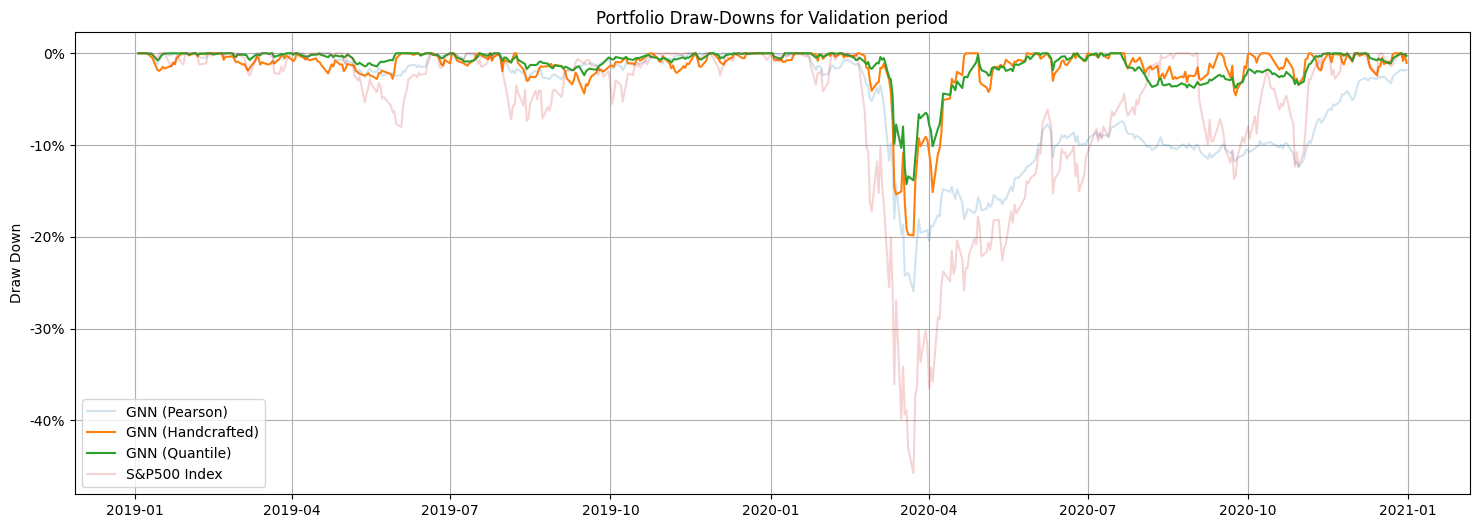

In [45]:
gnn_mis_pearson_mdd_val = drawdown_pct(gnn_mis_pearson_returns_cum_val)
# gnn_mis_dcor_mdd_val = drawdown_pct(gnn_mis_dcor_returns_cum_val)
gnn_mis_handcrafted_mdd_val = drawdown_pct(gnn_mis_handcrafted_returns_cum_val)
gnn_mis_quantile_mdd_val = drawdown_pct(gnn_mis_quantile_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)

gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)
gspc_equal_mdd_val = drawdown_pct(gspc_equal_returns_cum_val)

# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_val, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_mdd_val, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_mdd_val, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_mdd_val, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)

# ax.plot(solver_mis_mdd_val, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_mdd_val, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_mdd_val, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Portfolio Draw-Downs for Validation period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [46]:
# Sharpe Ratios
df_sharpe_val = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sharpe_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    # annualized_sharpe_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_val['Avg'] = df_sharpe_val.mean(axis=1)
df_sharpe_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_val.index), df_sharpe_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_val.index = multi_idx
df_sharpe_val.round(2)

2019  2020   Avg
Metric Portfolio                          
Sharpe GNN (Pearson)      2.43 -0.00  1.21
       GNN (Handcrafted)  2.06  1.17  1.61
       GNN (Quantile)     2.54  0.66  1.60
       S&P500 Index       2.01  0.58  1.29

In [47]:
# Sortino Ratios
df_sortino_val = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sortino_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    # annualized_sortino_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_sortino_val['Avg'] = df_sortino_val.mean(axis=1)
df_sortino_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_val.index), df_sortino_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_val.index = multi_idx
df_sortino_val.round(2)

2019  2020   Avg
Metric  Portfolio                          
Sortino GNN (Pearson)      3.32 -0.00  1.66
        GNN (Handcrafted)  3.40  1.39  2.40
        GNN (Quantile)     3.69  0.67  2.18
        S&P500 Index       2.48  0.66  1.57

In [48]:
# Maximal Draw Down
df_mdd_val = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_val, name='GNN (Pearson)'),
    # annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_val, name='GNN (Dist. Corr.)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_val, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_returns_val, name='GNN (Quantile)'),
    # annualized_max_drawdown(df_returns=solver_mis_returns_val, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_val, name='S&P500 Index'),
    # annualized_max_drawdown(df_returns=gspc_equal_returns_val, name='S&P500 Equal')

], axis=1).T

df_mdd_val['Avg'] = df_mdd_val.mean(axis=1)
df_mdd_val.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_val.index), df_mdd_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_val.index = multi_idx
df_mdd_val.round(2)

2019  2020   Avg
Metric Portfolio                          
MDD    GNN (Pearson)     -0.03 -0.26 -0.14
       GNN (Handcrafted) -0.04 -0.20 -0.12
       GNN (Quantile)    -0.02 -0.14 -0.08
       S&P500 Index      -0.08 -0.46 -0.27

In [49]:
# Calmar Ratios
df_calmar_val = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_calmar_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    # annualized_calmar_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),

], axis=1).T

df_calmar_val['Avg'] = df_calmar_val.mean(axis=1)
df_calmar_val.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_val.index), df_calmar_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_val.index = multi_idx
df_calmar_val.round(2)

2019  2020   Avg
Metric Portfolio                          
Calmar GNN (Pearson)      4.06 -0.00  2.03
       GNN (Handcrafted)  3.24  0.97  2.11
       GNN (Quantile)     3.67  0.52  2.09
       S&P500             3.12  0.44  1.78

## Retraining (Optional)

### Test

# stocks in pearson portfolio: 38
# stocks in handcrafted portfolio: 20
# stocks in dist. corr. portfolio: 37
# stocks in solver portfolio: 46


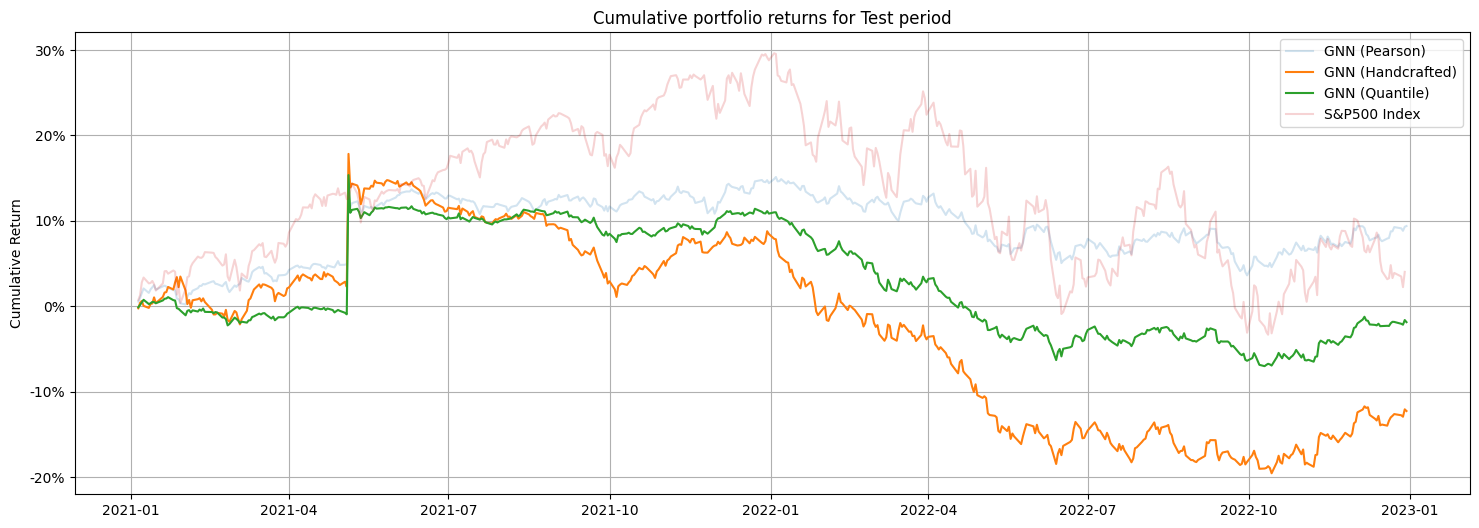

In [50]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_test, gnn_mis_pearson_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_pearson
)

# # GNN DCOR Portfolio
# print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
# gnn_mis_dcor_returns_test, gnn_mis_dcor_returns_cum_test = portfolio_return(
#     df=df_test,
#     assets=gnn_mis_set_dcor
# )

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_test, gnn_mis_handcrafted_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_handcrafted
)

# GNN Quantile Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile)}")
gnn_mis_quantile_returns_test, gnn_mis_quantile_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_quantile
)

# Solver MIS Portfolio
print(f"# stocks in solver portfolio: {len(solver_mis_set)}")
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = (gspc_returns_test + 1).cumprod() -1

# Benchmark all assets equally
gspc_equal_returns_test, gspc_equal_returns_cum_test = portfolio_return(
    df=df_test,
    assets=df_test.columns.to_list()
)

# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_test, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_returns_cum_test, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_returns_cum_test, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_returns_cum_test, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)
# ax.plot(solver_mis_returns_cum_test, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_returns_cum_test, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_returns_cum_test, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Cumulative portfolio returns for Test period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

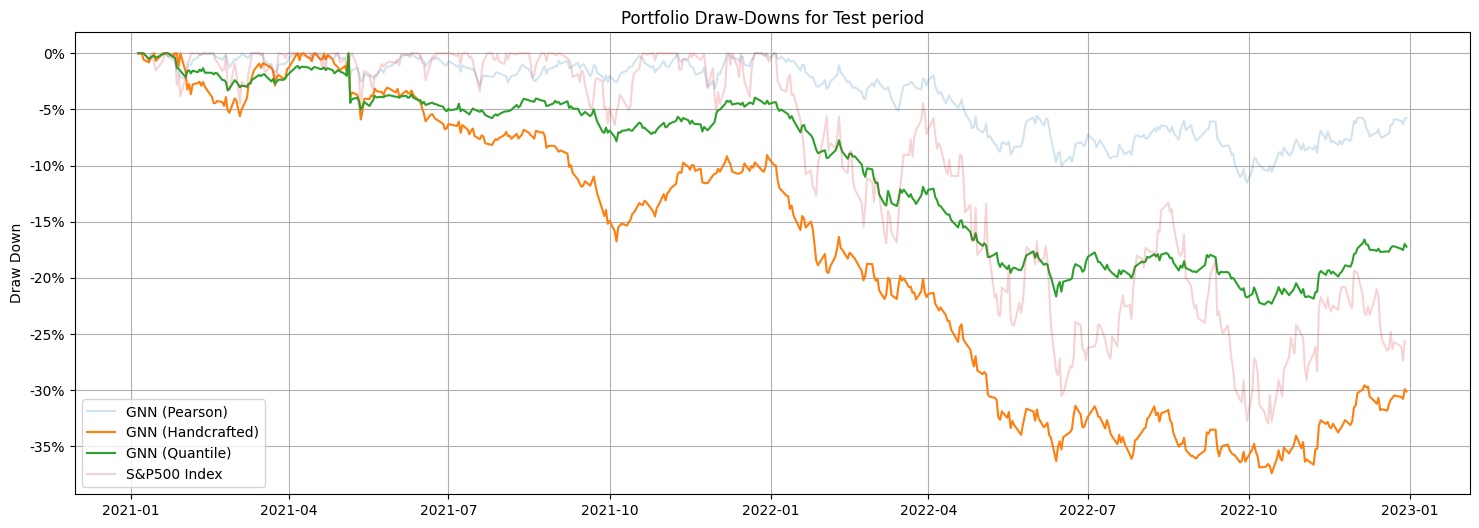

In [51]:
gnn_mis_pearson_mdd_test = drawdown_pct(gnn_mis_pearson_returns_cum_test)
# gnn_mis_dcor_mdd_test = drawdown_pct(gnn_mis_dcor_returns_cum_test)
gnn_mis_handcrafted_mdd_test = drawdown_pct(gnn_mis_handcrafted_returns_cum_test)
gnn_mis_quantile_mdd_test = drawdown_pct(gnn_mis_quantile_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)
gspc_equal_mdd_test = drawdown_pct(gspc_equal_returns_cum_test)

# Plot
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_test, label="GNN (Pearson)", alpha=ALPHA_VAL_LOW)
# ax.plot(gnn_mis_dcor_mdd_test, label="GNN (Dist. Corr.)", alpha=ALPHA_VAL_LOW)
ax.plot(gnn_mis_handcrafted_mdd_test, label="GNN (Handcrafted)", alpha=ALPHA_VAL_HIGH)
ax.plot(gnn_mis_quantile_mdd_test, label="GNN (Quantile)", alpha=ALPHA_VAL_HIGH)
# ax.plot(solver_mis_mdd_test, label="Solver", alpha=ALPHA_VAL_LOW)

ax.plot(gspc_mdd_test, label="S&P500 Index", alpha=ALPHA_VAL_LOW)
# ax.plot(gspc_equal_mdd_test, label="S&P500 equally", alpha=ALPHA_VAL_LOW)

ax.set_title("Portfolio Draw-Downs for Test period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [52]:
# Sharpe Ratios
df_sharpe_test = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sharpe_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sharpe_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_test['Avg'] = df_sharpe_test.mean(axis=1)
df_sharpe_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_test.index), df_sharpe_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_test.index = multi_idx
df_sharpe_test.round(2)

2021  2022   Avg
Metric Portfolio                          
Sharpe GNN (Pearson)      1.28 -0.65  0.32
       GNN (Handcrafted)  0.48 -1.64 -0.58
       GNN (Quantile)     0.61 -1.71 -0.55
       S&P500 Index       1.93 -0.81  0.56
       S&P500 equally     1.39 -0.72  0.33

In [53]:
# Sortino Ratios
df_sortino_test = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_sortino_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_sortino_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Index'),
    # annualized_sortino_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),
], axis=1).T

df_sortino_test['Avg'] = df_sortino_test.mean(axis=1)
df_sortino_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_test.index), df_sortino_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_test.index = multi_idx
df_sortino_test.round(2)

2021  2022   Avg
Metric  Portfolio                          
Sortino GNN (Pearson)      2.84 -1.04  0.90
        GNN (Handcrafted)  1.25 -2.70 -0.73
        GNN (Quantile)     1.82 -2.82 -0.50
        S&P500 Index       2.75 -1.29  0.73

In [54]:
# Maximal Draw Down
df_mdd_test = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_test, name='GNN (Pearson)'),
    # annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_test, name='GNN (Dist. Corr.)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_test, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_returns_test, name='GNN (Quantile)'),
    # annualized_max_drawdown(df_returns=solver_mis_returns_test, name='Solver'),
    annualized_max_drawdown(df_returns=gspc_returns_test, name='S&P500 Index'),
    # annualized_max_drawdown(df_returns=gspc_equal_returns_test, name='S&P500 Equal')
], axis=1).T

df_mdd_test['Avg'] = df_mdd_test.mean(axis=1)
df_mdd_test.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_test.index), df_mdd_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_test.index = multi_idx
df_mdd_test.round(2)

2021  2022   Avg
Metric Portfolio                          
MDD    GNN (Pearson)     -0.03 -0.12 -0.07
       GNN (Handcrafted) -0.17 -0.37 -0.27
       GNN (Quantile)    -0.08 -0.22 -0.15
       S&P500 Index      -0.06 -0.33 -0.20

In [55]:
# Calmar Ratios
df_calmar_test = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    # annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Dist. Corr.)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile)'),
    # annualized_calmar_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Solver'),
    annualized_calmar_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500'),
    # annualized_calmar_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 Equal'),
], axis=1).T

df_calmar_test['Avg'] = df_calmar_test.mean(axis=1)
df_calmar_test.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_test.index), df_calmar_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_test.index = multi_idx
df_calmar_test.round(2)

2021  2022   Avg
Metric Portfolio                          
Calmar GNN (Pearson)      4.08 -0.45  1.82
       GNN (Handcrafted)  0.51 -0.57 -0.03
       GNN (Quantile)     1.36 -0.58  0.39
       S&P500             3.94 -0.59  1.67